# g1-4_v037
逐次異常値除去

In [23]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
import scipy.interpolate
import scipy.sparse

In [24]:
area_labeling = pd.read_csv('../output/prep/area_labeling/result.csv')

g1 = list(area_labeling[area_labeling['g']==1]['collectionName'])
g2 = list(area_labeling[area_labeling['g']==2]['collectionName'])
g3 = list(area_labeling[area_labeling['g']==3]['collectionName'])
g4 = list(area_labeling[area_labeling['g']==4]['collectionName'])
g5 = list(area_labeling[area_labeling['g']==5]['collectionName'])

In [25]:
target = g1 + g2 + g3 + g4

In [26]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = g3 + g4

In [27]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [28]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [29]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [30]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [31]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [32]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [33]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [34]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [35]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [36]:
def update_baseline(df, rb):
    rb = rb.rename(columns={'latDeg':'latDeg_rb', 'lngDeg':'lngDeg_rb'})
    df = df.merge(rb[['millisSinceGpsEpoch', 'phone', 'latDeg_rb', 'lngDeg_rb']], on=['millisSinceGpsEpoch', 'phone'], how='left')

    idx = df[~df['latDeg_rb'].isnull()].index
    df.loc[idx, 'latDeg'] = df.loc[idx, 'latDeg_rb']
    df.loc[idx, 'lngDeg'] = df.loc[idx, 'lngDeg_rb']
    
    df.drop(columns=['latDeg_rb', 'lngDeg_rb'], inplace=True)
    
    return df

# 自前再構成baselineに更新

In [37]:
train, test, sub, gt = get_data()

In [38]:
train = train[train['collectionName'].isin(target)].copy()
train = train.reset_index(drop=True)

In [39]:
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g1_v001/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g2_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g3_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g4_v002/result.csv'))

# ML結果を結合

In [40]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
train = train.merge(train_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

dp_train = pd.read_csv('../output/prep/rel_pred_v001/train_result.csv')
train = train.merge(dp_train[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
train.loc[train['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

# 逐次異常値除去

In [19]:
def seq_ro(df, dist_th):
    df_org = df.copy()
    df_idx = list(df.index)
    reject_idx = []
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg']
        lng = df.at[idx, 'lngDeg']
        lat_diff = df.at[idx, 'lat_diff']
        lng_diff = df.at[idx, 'lng_diff']
        t = df.at[idx, 'millisSinceGpsEpoch']
        lat_next = df.at[idx+1, 'latDeg']
        lng_next = df.at[idx+1, 'lngDeg']
        t_next = df.at[idx+1, 'millisSinceGpsEpoch']
        
        t_diff = (t_next - t) / 1000
        dist = calc_haversine(lat, lng, lat_next, lng_next)
        dist = dist / t_diff
        
        if dist > dist_th:
            df.at[idx+1, 'latDeg'] = lat + lat_diff
            df.at[idx+1, 'lngDeg'] = lng + lng_diff
            reject_idx.append(idx)
    
    reject_df = df_org.loc[reject_idx].copy()
    return df, reject_df

In [20]:
train, train_reject = seq_ro(train, dist_th=50)

In [21]:
train_reject

collectionName phoneName  millisSinceGpsEpoch     latDeg  \
493     2020-05-14-US-MTV-1    Pixel4        1273529956442  37.469006   
494     2020-05-14-US-MTV-1    Pixel4        1273529957442  37.467869   
495     2020-05-14-US-MTV-1    Pixel4        1273529958442  37.469239   
496     2020-05-14-US-MTV-1    Pixel4        1273529959442  37.469364   
497     2020-05-14-US-MTV-1    Pixel4        1273529960442  37.469492   
...                     ...       ...                  ...        ...   
113568  2021-04-29-US-MTV-1    Pixel4        1303770501653  37.395750   
113569  2021-04-29-US-MTV-1    Pixel4        1303770502644  37.395738   
113570  2021-04-29-US-MTV-1    Pixel4        1303770503656  37.395931   
113571  2021-04-29-US-MTV-1    Pixel4        1303770504649  37.395717   
113572  2021-04-29-US-MTV-1    Pixel4        1303770505640  37.395761   

            lngDeg  heightAboveWgs84EllipsoidM                       phone  \
493    -122.154513                        6.47  2020-05-14-US-MTV-1_Pixel4   
494    -122.156559                      -21.12  2020-05-14-US-MTV-1_Pixel4   
495    -122.155605                      -33.42  2020-05-14-US-MTV-1_Pixel4   
496    -122.155833                      -31.34  2020-05-14-US-MTV-1_Pixel4   
497    -122.156069                      -30.12  2020-05-14-US-MTV-1_Pixel4   
...            ...                         ...                         ...   
113568 -122.102851                      -10.94  2021-04-29-US-MTV-1_Pixel4   
113569 -122.102817                       30.62  2021-04-29-US-MTV-1_Pixel4   
113570 -122.102901                      -37.19  2021-04-29-US-MTV-1_Pixel4   
113571 -122.102876                      -18.98  2021-04-29-US-MTV-1_Pixel4   
113572 -122.103094                      -49.75  2021-04-29-US-MTV-1_Pixel4   

        isSpeed0  lat_diff  lng_diff  
493            0  0.000128 -0.000258  
494            0  0.000133 -0.000212  
495            0  0.000141 -0.000241  
496            0  0.000136 -0.000240  
497            0  0.000136 -0.000233  
...          ...       ...       ...  
113568         1  0.000000  0.000000  
113569         1  0.000000  0.000000  
113570         1  0.000000  0.000000  
113571         1  0.000000  0.000000  
113572         1  0.000000  0.000000  

[8495 rows x 10 columns]

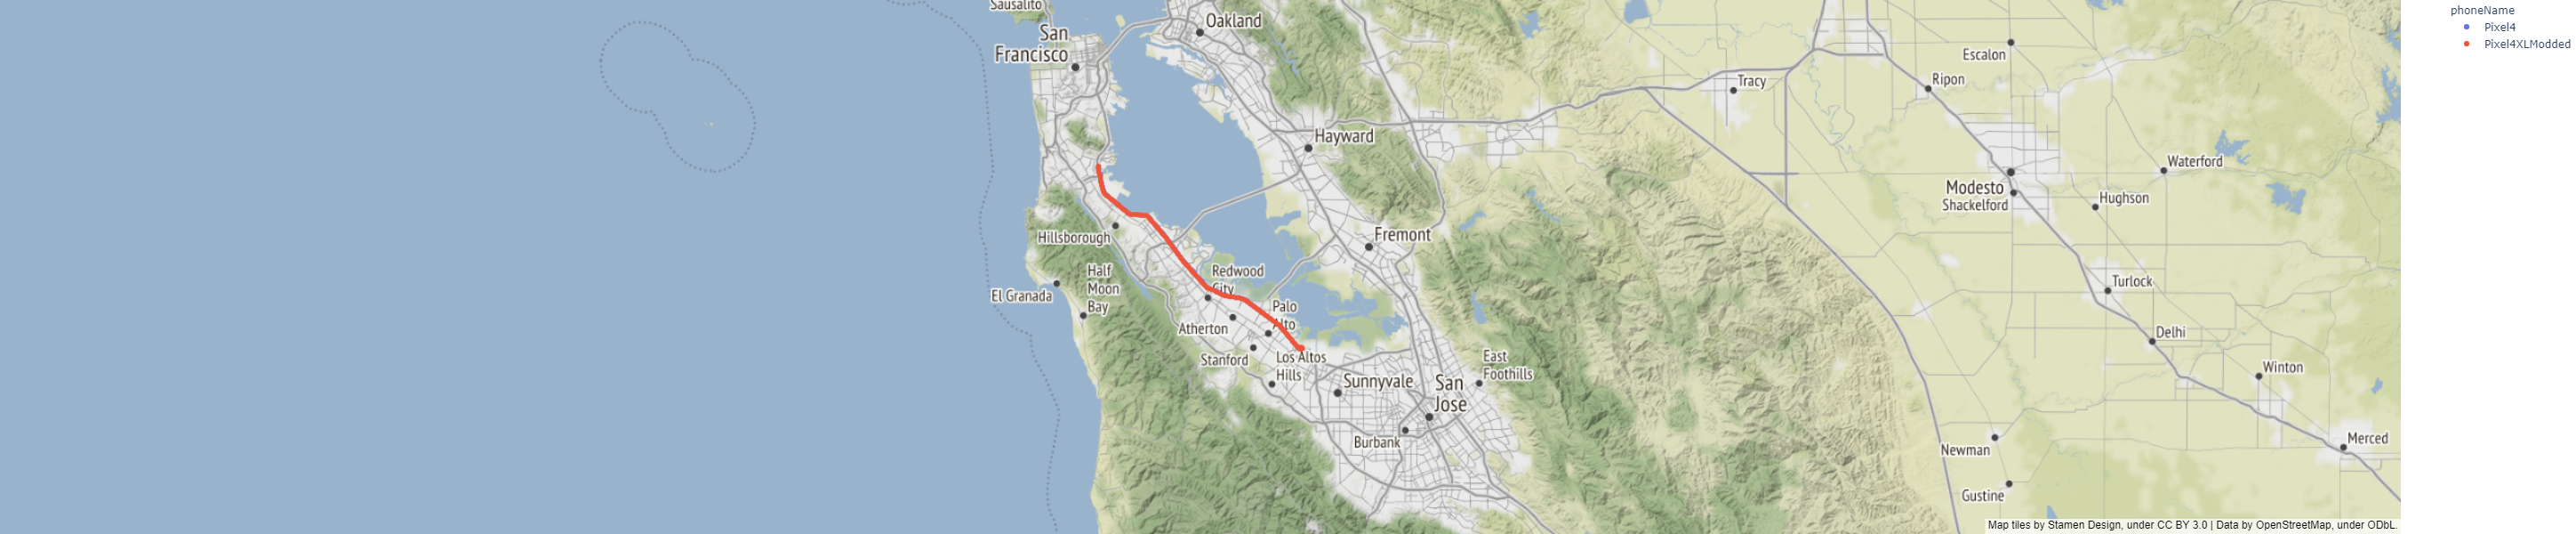

In [22]:
visualize_collection(train, '2020-05-14-US-MTV-1')

# ground_truthを基準にした外れ値除去

In [19]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [20]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if collection in ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']:
            th = 3
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [21]:
def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

In [22]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df = interpolate_remove_point(rog_df)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]
train.to_csv(OUTPUT + '/train_ro_rog.csv', index=False)

# kalmanフィルタ

In [23]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [24]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_kf.csv', index=False)

# speed0の処理

In [25]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [26]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train = sp0_process(train, train_sp0_pred)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0.csv', index=False)

In [27]:
train = pd.read_csv(OUTPUT + '/train_ro_rog_kf_sp0.csv')

# cost_minimization

In [28]:
def cost_minimization(df, b):
    xy_hat = df[['latDeg', 'lngDeg']].to_numpy()
    delta_xy_hat = df[['lat_diff', 'lng_diff']].fillna(method='ffill')[:-1].to_numpy()

    N = xy_hat.shape[0]
    alpha = 0.01 * np.ones(N)
    beta  = b * np.ones(N-1)

    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags(beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return xy_star

In [29]:
dp_train = pd.read_csv('../output/prep/rel_pred_v001/train_result.csv')
train = train.merge(dp_train[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
train.loc[train['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

In [30]:
def cost_min_objective(trial):
    cost_min_beta_g1 = trial.suggest_uniform('cost_min_beta_g1', 0.01, 0.5)
    cost_min_beta_g2 = trial.suggest_uniform('cost_min_beta_g2', 0.01, 0.5)
    cost_min_beta_g3 = trial.suggest_uniform('cost_min_beta_g3', 0.01, 0.5)
    cost_min_beta_g4 = trial.suggest_uniform('cost_min_beta_g4', 0.01, 0.5)
    train_ = train.copy()
    
    for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
        phones = train[(train['collectionName'].isin(g))&(train['phoneName']!='Mi8')]['phone'].unique()
        for phone in phones:
            idx = train[train['phone']==phone].index
            train_.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train_.loc[idx], w)
    score = train_result(train_[train_['collectionName'].isin(target)]).score
    return score

In [31]:
study = optuna.create_study()
study.optimize(cost_min_objective, n_trials=100)
print(study.best_params)

cost_min_beta_g1 = study.best_params['cost_min_beta_g1']
cost_min_beta_g2 = study.best_params['cost_min_beta_g2']
cost_min_beta_g3 = study.best_params['cost_min_beta_g3']
cost_min_beta_g4 = study.best_params['cost_min_beta_g4']

[I 2021-07-30 22:04:00,823] A new study created in memory with name: no-name-1c93f94d-1e0e-4629-93b5-1fab78e6e274
[I 2021-07-30 22:04:02,331] Trial 0 finished with value: 2.769122256377463 and parameters: {'cost_min_beta_g1': 0.15136203168943269, 'cost_min_beta_g2': 0.18332051788716966, 'cost_min_beta_g3': 0.24298349752408338, 'cost_min_beta_g4': 0.4856399375106599}. Best is trial 0 with value: 2.769122256377463.
[I 2021-07-30 22:04:03,809] Trial 1 finished with value: 2.8486110006928205 and parameters: {'cost_min_beta_g1': 0.2533799842235993, 'cost_min_beta_g2': 0.3682962382932684, 'cost_min_beta_g3': 0.2625135551280944, 'cost_min_beta_g4': 0.03994018824170536}. Best is trial 0 with value: 2.769122256377463.
[I 2021-07-30 22:04:05,291] Trial 2 finished with value: 2.8569483139370746 and parameters: {'cost_min_beta_g1': 0.2589796827808895, 'cost_min_beta_g2': 0.46803626299336, 'cost_min_beta_g3': 0.4768550076029253, 'cost_min_beta_g4': 0.09521263079009416}. Best is trial 0 with value: 

{'cost_min_beta_g1': 0.0548578377681917, 'cost_min_beta_g2': 0.04092021795972425, 'cost_min_beta_g3': 0.3993258577626849, 'cost_min_beta_g4': 0.49629402822811847}


In [32]:
for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
    phones = train[(train['collectionName'].isin(g))&(train['phoneName']!='Mi8')]['phone'].unique()
    for phone in phones:
        idx = train[train['phone']==phone].index
        train.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train.loc[idx], w)
print(train_result(train[train['collectionName'].isin(target)]).score)

2.7358934110320896


# phones_weighted_mean

In [33]:
train_ = train[train['collectionName'].isin(target)].copy()

In [34]:
def calc_mean_pred(df, ws):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list = df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    tmp['phone'] = tmp['collectionName'] + '_' + tmp['phoneName']
    tmp = tmp.merge(df, on=['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch'], how='left')
    
    lerp_df = pd.DataFrame()
    for phone in tmp['phone'].unique():
        lerp_tmp = tmp[tmp['phone']==phone].copy()
        lerp_tmp = lerp_tmp.sort_values('millisSinceGpsEpoch')
        lerp_tmp = lerp_tmp.set_index('millisSinceGpsEpoch')
        lerp_tmp[['latDeg', 'lngDeg']] = lerp_tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        lerp_tmp = lerp_tmp.reset_index()
        lerp_df = lerp_df.append(lerp_tmp)
    
    lerp_df['w'] = lerp_df['phoneName'].replace(ws)
    lerp_df.loc[lerp_df['latDeg'].isnull(), 'w'] = np.nan
    lerp_df['w_sum'] = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['w'].transform('sum')
    lerp_df['w'] = lerp_df['w'] / lerp_df['w_sum']
    lerp_df['latDeg'] = lerp_df['latDeg'] * lerp_df['w']
    lerp_df['lngDeg'] = lerp_df['lngDeg'] * lerp_df['w']
    mean_pred = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['latDeg', 'lngDeg'].sum().reset_index()
    
    output_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    output_df = output_df.merge(mean_pred[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return output_df

In [35]:
def phones_mean_objective(trial):
    Pixel4 = trial.suggest_int('Pixel4', 1, 10)
    Pixel4XLModded = trial.suggest_int('Pixel4XLModded', 1, 10)
    Pixel4XL = trial.suggest_int('Pixel4XL', 1, 10)
    Mi8 = trial.suggest_int('Mi8', 1, 10)
    Pixel4Modded = trial.suggest_int('Pixel4Modded', 1, 10)
    Pixel5 = trial.suggest_int('Pixel5', 1, 10)
    SamsungS20Ultra = trial.suggest_int('SamsungS20Ultra', 1, 10)
    
    ws = {'Pixel4':Pixel4, 'Pixel4XLModded':Pixel4XLModded, 'Pixel4XL':Pixel4XL, 'Mi8':Mi8, 'Pixel4Modded':Pixel4Modded,
          'Pixel5':Pixel5, 'SamsungS20Ultra':SamsungS20Ultra}
    
    out = calc_mean_pred(train_, ws)
    score = train_result(out).score
    
    return score

In [36]:
study = optuna.create_study()
study.optimize(phones_mean_objective, n_trials=100)
phones_mean_weights = study.best_params
print(phones_mean_weights)

[I 2021-07-30 22:06:33,023] A new study created in memory with name: no-name-6f13fae4-9b8a-4268-b28b-310199668b14
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
[I 2021-07-30 22:06:39,048] Trial 0 finished with value: 2.3148884733548565 and parameters: {'Pixel4': 6, 'Pixel4XLModded': 1, 'Pixel4XL': 10, 'Mi8': 3, 'Pixel4Modded': 9, 'Pixel5': 2, 'SamsungS20Ultra': 1}. Best is trial 0 with value: 2.3148884733548565.
[I 2021-07-30 22:06:44,805] Trial 1 finished with value: 2.35229118373296 and parameters: {'Pixel4': 2, 'Pixel4XLModded': 1, 'Pixel4XL': 7, 'Mi8': 3, 'Pixel4Modded': 10, 'Pixel5': 1, 'SamsungS20Ultra': 3}. Best is trial 0 with value: 2.3148884733548565.
[I 2021-07-30 22:06:50,631] Trial 2 finished with value: 2.370515680708353 and parameters: {'Pixel4': 7, 'Pixel4XLModded': 1, 'Pixel4XL': 6, 'Mi8': 3, 'Pixel4Modded': 5, 'Pixel5': 5, 'Sa

{'Pixel4': 3, 'Pixel4XLModded': 1, 'Pixel4XL': 2, 'Mi8': 4, 'Pixel4Modded': 8, 'Pixel5': 4, 'SamsungS20Ultra': 1}


In [37]:
train = calc_mean_pred(train, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


# position_shift

In [38]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [39]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [40]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [41]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-07-30 22:16:33,250] A new study created in memory with name: no-name-a557c54a-781c-4ebc-a2fa-544bdb2f3f4e
[I 2021-07-30 22:16:38,874] Trial 0 finished with value: 2.8756739109086293 and parameters: {'a': -0.006168549538510648}. Best is trial 0 with value: 2.8756739109086293.
[I 2021-07-30 22:16:44,695] Trial 1 finished with value: 2.909993139147149 and parameters: {'a': 0.9714017693718038}. Best is trial 0 with value: 2.8756739109086293.
[I 2021-07-30 22:16:50,344] Trial 2 finished with value: 2.8616111036525873 and parameters: {'a': 0.06639416833026401}. Best is trial 2 with value: 2.8616111036525873.
[I 2021-07-30 22:16:55,937] Trial 3 finished with value: 2.8775234495666133 and parameters: {'a': -0.014627156201875602}. Best is trial 2 with value: 2.8616111036525873.
[I 2021-07-30 22:17:01,710] Trial 4 finished with value: 2.835366111618509 and parameters: {'a': 0.5596777656011136}. Best is trial 4 with value: 2.835366111618509.
[I 2021-07-30 22:17:07,354] Trial 5 finished wi

0.447349047066386


In [42]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

In [43]:
train = train[train['collectionName'].isin(target)].copy()

# trainの結果確認

In [44]:
result = train_result(train)

In [45]:
result.score

2.176488563837687

In [46]:
result.err

percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               0.914429      1.534750      1.224590
2020-05-14-US-MTV-1_Pixel4XLModded       0.828151      1.481277      1.154714
2020-05-14-US-MTV-2_Pixel4               1.829171      2.655357      2.242264
2020-05-14-US-MTV-2_Pixel4XLModded       1.772560      3.076083      2.424321
2020-05-21-US-MTV-1_Pixel4               2.035066      3.567803      2.801435
2020-05-21-US-MTV-2_Pixel4               0.632433      2.344211      1.488322
2020-05-21-US-MTV-2_Pixel4XL             0.583011      2.231723      1.407367
2020-05-29-US-MTV-1_Pixel4               1.754678      2.542146      2.148412
2020-05-29-US-MTV-1_Pixel4XL             1.734000      2.542835      2.138418
2020-05-29-US-MTV-1_Pixel4XLModded       1.737175      2.550346      2.143761
2020-05-29-US-MTV-2_Pixel4               2.257854      3.737062      2.997458
2020-05-29-US-MTV-2_Pixel4XL             2.189544      3.754190      2.971867
2020-06-04-US-MTV-1_Pixel4               0.839259      2.027237      1.433248
2020-06-04-US-MTV-1_Pixel4XL             0.903891      2.059486      1.481688
2020-06-04-US-MTV-1_Pixel4XLModded       0.912712      2.373876      1.643294
2020-06-05-US-MTV-1_Pixel4               0.944769      2.708046      1.826407
2020-06-05-US-MTV-1_Pixel4XL             0.990237      2.791085      1.890661
2020-06-05-US-MTV-1_Pixel4XLModded       0.937573      3.681619      2.309596
2020-06-05-US-MTV-2_Pixel4               0.967536      2.659956      1.813746
2020-06-05-US-MTV-2_Pixel4XL             0.911796      2.563512      1.737654
2020-06-11-US-MTV-1_Pixel4               0.756225      1.769913      1.263069
2020-06-11-US-MTV-1_Pixel4XL             0.828493      1.844344      1.336419
2020-07-08-US-MTV-1_Pixel4               0.892082      1.932001      1.412042
2020-07-08-US-MTV-1_Pixel4XL             0.866456      1.847892      1.357174
2020-07-08-US-MTV-1_Pixel4XLModded       0.753018      1.636064      1.194541
2020-07-17-US-MTV-1_Mi8                  1.764774      3.434432      2.599603
2020-07-17-US-MTV-2_Mi8                  2.845926      4.194161      3.520044
2020-08-03-US-MTV-1_Mi8                  1.546709      2.561640      2.054175
2020-08-03-US-MTV-1_Pixel4               1.683253      2.675102      2.179177
2020-08-06-US-MTV-2_Mi8                  0.871686      1.972425      1.422055
2020-08-06-US-MTV-2_Pixel4               0.945325      2.013236      1.479281
2020-08-06-US-MTV-2_Pixel4XL             0.959254      2.044468      1.501861
2020-09-04-US-SF-1_Mi8                   1.136224      3.224217      2.180220
2020-09-04-US-SF-1_Pixel4                1.187973      3.653143      2.420558
2020-09-04-US-SF-1_Pixel4XL              1.154094      3.362341      2.258217
2020-09-04-US-SF-2_Mi8                   1.198971      5.378912      3.288942
2020-09-04-US-SF-2_Pixel4                0.996335      3.434451      2.215393
2020-09-04-US-SF-2_Pixel4XL              1.022539      3.992169      2.507354
2021-01-04-US-RWC-1_Pixel4               0.829292      2.013647      1.421469
2021-01-04-US-RWC-1_Pixel4Modded         1.032263      2.169743      1.601003
2021-01-04-US-RWC-1_Pixel4XL             0.868279      2.070849      1.469564
2021-01-04-US-RWC-1_Pixel5               0.874947      2.062767      1.468857
2021-01-04-US-RWC-2_Pixel4               1.033430      2.537188      1.785309
2021-01-04-US-RWC-2_Pixel4Modded         1.230040      2.664682      1.947361
2021-01-04-US-RWC-2_Pixel4XL             1.030726      2.507530      1.769128
2021-01-04-US-RWC-2_Pixel5               1.098511      2.842606      1.970559
2021-01-05-US-SVL-1_Mi8                  1.281630      2.987724      2.134677
2021-01-05-US-SVL-1_Pixel4               1.518955      3.152513      2.335734
2021-01-05-US-SVL-1_Pixel4XL             1.479423      3.056362      2.267892
2021-01-05-US-SVL-1_Pixel5               1.416920      2.96

In [47]:
train.to_csv(OUTPUT + f'/{nb_name}_train.csv', index=False)

# make_sub

In [48]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')

In [49]:
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g1_v001/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g2_v003/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g3_v003/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g4_v002/result_test.csv'))

In [50]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [51]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df.to_csv(OUTPUT + '/test_rog.csv', index=False)
rog_df = interpolate_remove_point(rog_df)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [52]:
test = apply_kf_smoothing(test)

In [53]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')
test = sp0_process(test, test_sp0_pred)

In [54]:
dp_test = pd.read_csv('../output/prep/rel_pred_v001/test_result.csv')
test = test.merge(dp_test[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
test.loc[test['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
    phones = test[(test['collectionName'].isin(g))&(test['phoneName']!='Mi8')]['phone'].unique()
    for phone in phones:
        idx = test[test['phone']==phone].index
        test.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(test.loc[idx], w)

In [55]:
test = calc_mean_pred(test, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [56]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']

In [57]:
test = position_shift(test, opt_a)

In [58]:
test = test[test['collectionName'].isin(target)]

In [59]:
test.to_csv(OUTPUT + f'/{nb_name}_test.csv', index=False)